# CKA Similarity Analysis
In this notebook we explore the CKA similarity metric with quantized models.

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import ast
import os
import sys


# import modules from RN08 model
module_path = os.path.abspath(os.path.join('../../workspace/models/rn08/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import rn08

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import q_autoencoder as econ
import autoencoder_datamodule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from CKA import CKA



## Utility methods

In [2]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()

In [3]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
cka_batch_num = 50000

# ECON model (Autoencoder)
we focus our analysis on the encoder which will be deploy on an ASIC.

In [4]:
DATA_PATH = '/data/tbaldi/work/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'
ECON_layers = ['encoder.conv', 'encoder.enc_dense']

In [5]:
def get_cka_per_model(batch_size, 
                      learning_rate, 
                      precision, 
                      size,
                      dataloader,
                      activation_layers=ECON_layers,
                      max_batches=cka_batch_num):
    # load the model
    model, _ = econ.load_model(DATA_PATH, batch_size, learning_rate, precision, size)
    
    # init the metric
    cka = CKA(model, 
              dataloader, 
              layers=activation_layers,
              max_batches=max_batches)
    
    return cka

## Result

In [6]:
# During the computation of the CKA similarity both the model must process the same data, 
# so we create a cka_dataloader equal for all the models which we will use to carry on our
# test
data_module = autoencoder_datamodule.get_data_module(DATASET_DIR, DATASET_FILE, 16)
cka_dataloader = data_module.test_dataloader()
noise_type = 'gaussian'
noise = 5 # 5 10 15 20

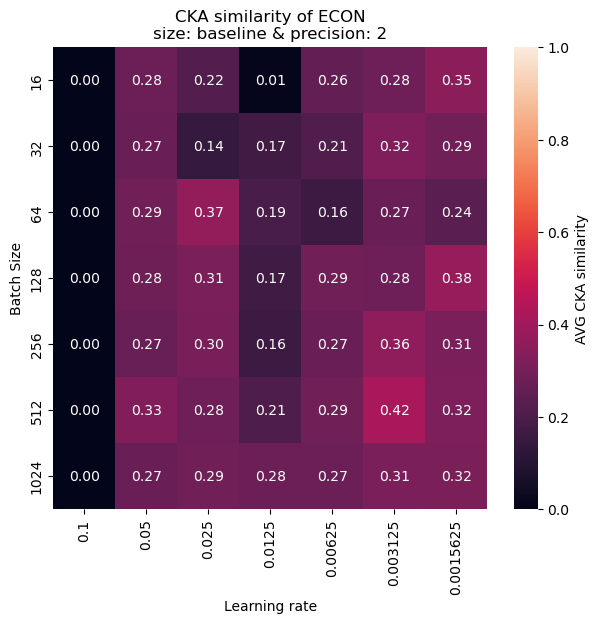

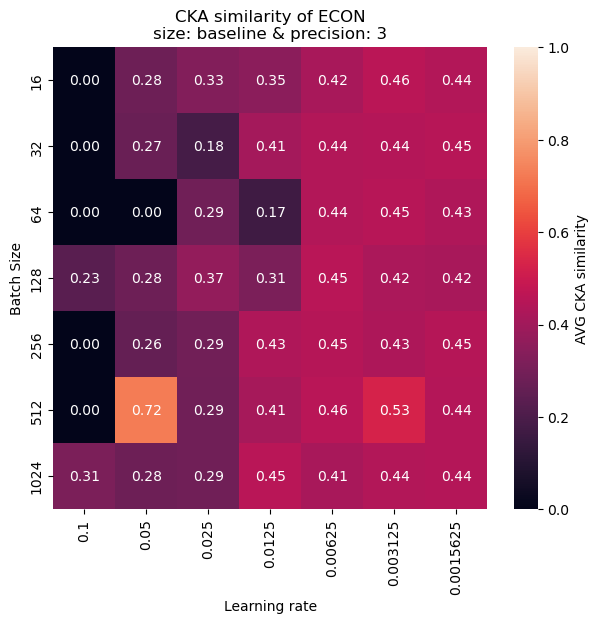

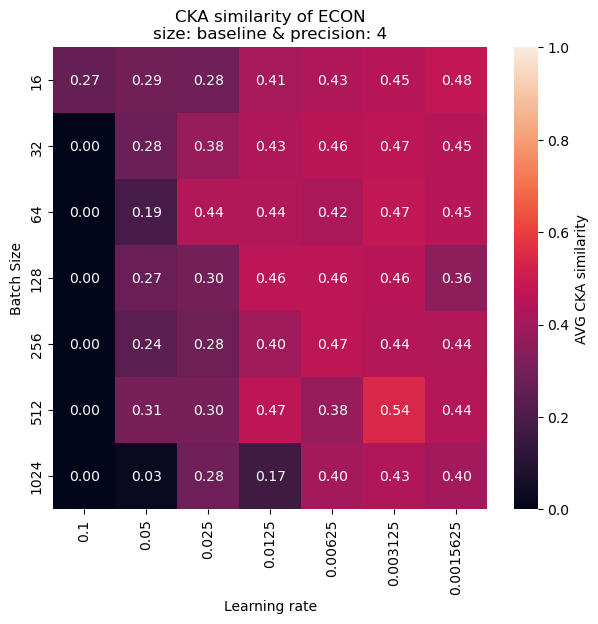

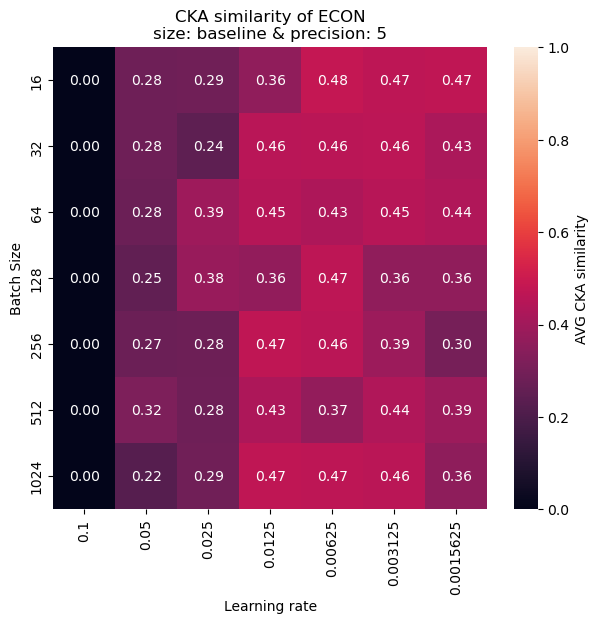

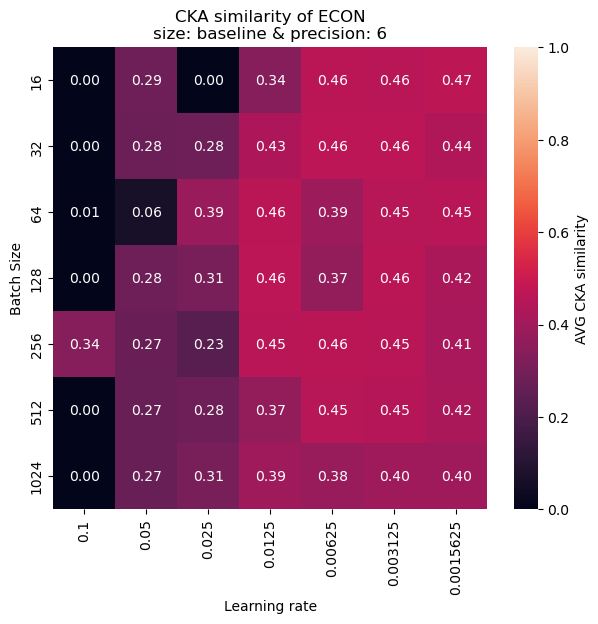

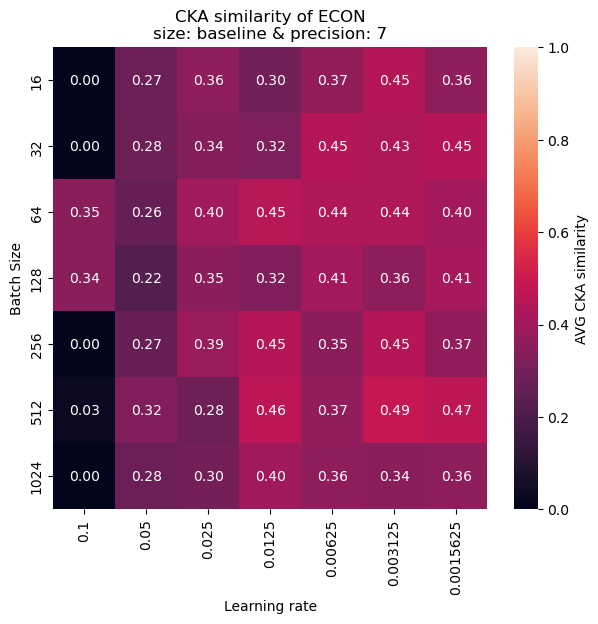

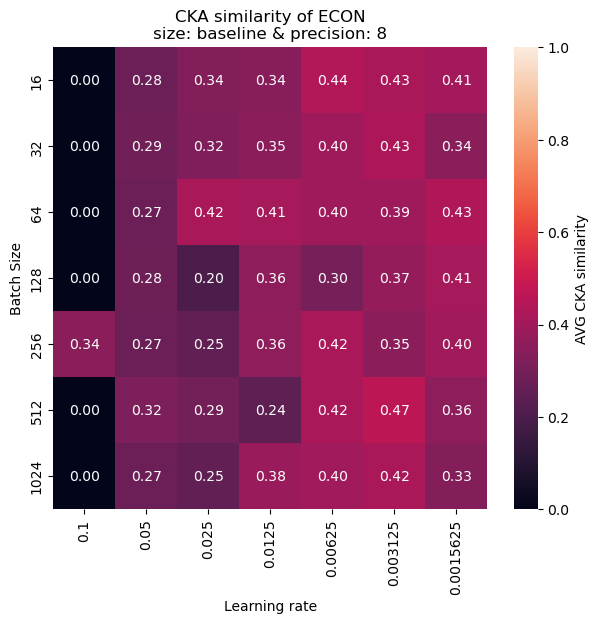

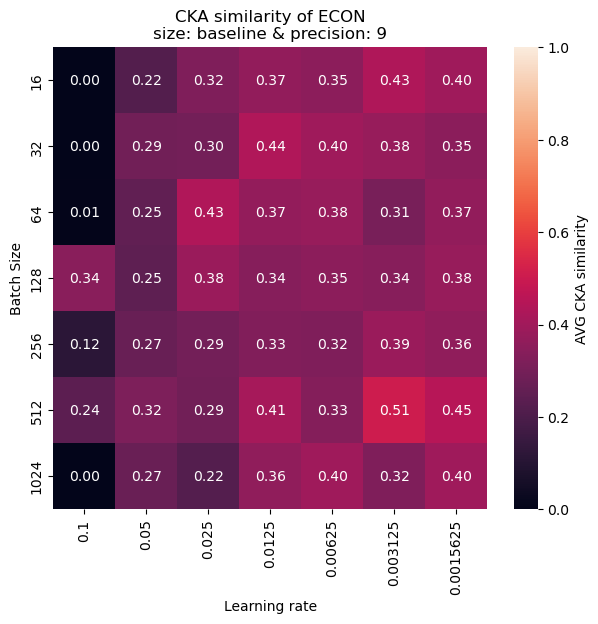

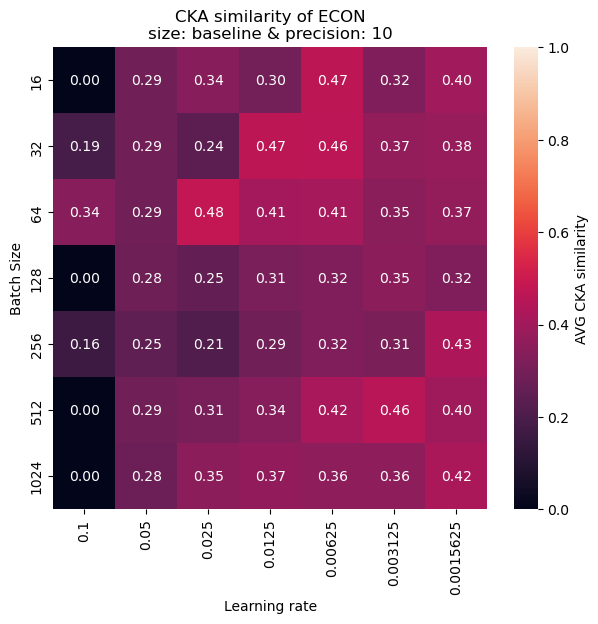

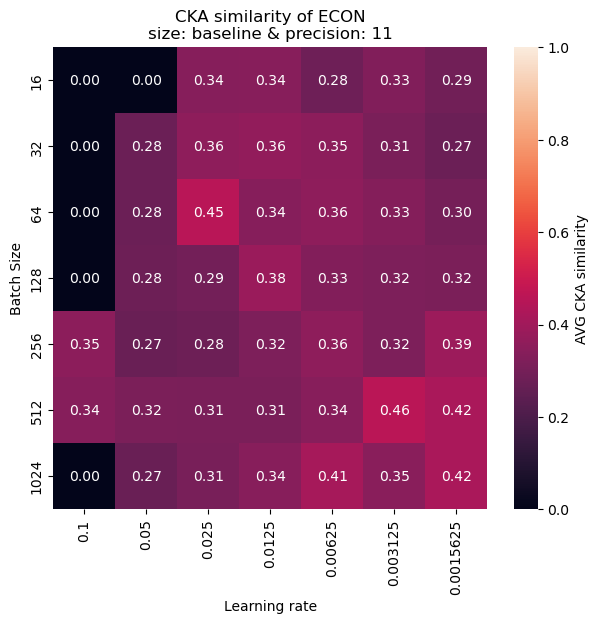

In [7]:
cka_distribution = []
for p in precisions:
    CKA_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # get the performance of the model with and without noise
            mean_emd, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            noise_emd = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, noise)
            # path to the directory
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/ECON_{p}b/{size}/')
            # get the metric
            cka = get_cka_per_model(bs,
                                    lr,
                                    p,
                                    size,
                                    cka_dataloader,
                                    ECON_layers,
                                    max_batches=cka_batch_num)
            
            # load the results
            avg_cka = -1
            if cka.load_from_file(path):
                avg_cka = cka.results['CKA_similarity']
                

            # build the heatmap
            CKA_matrix[x, y] = avg_cka
            
            # build the dataframe for further analysis
            cka_distribution.append({
                'precision': p, 
                'avg_cka': avg_cka,
                'emd': mean_emd,
                'noise_emd': noise_emd,
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (noise_emd - mean_emd) * 100 / mean_emd,
            })
            
            
    CKA_matrix = pd.DataFrame(CKA_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    plot_2d_heatmap(CKA_matrix, 
                    f'CKA similarity of ECON\nsize: {size} & precision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'AVG CKA similarity',
                    cmap='rocket')

In [8]:
cka_distribution_df = pd.DataFrame(cka_distribution)
# export as CSV
cka_distribution_df.to_csv('./results/econ/cka.csv', index=False)

There is no correlation between the batch size and the robustness, so we want to plot it based onthe precision

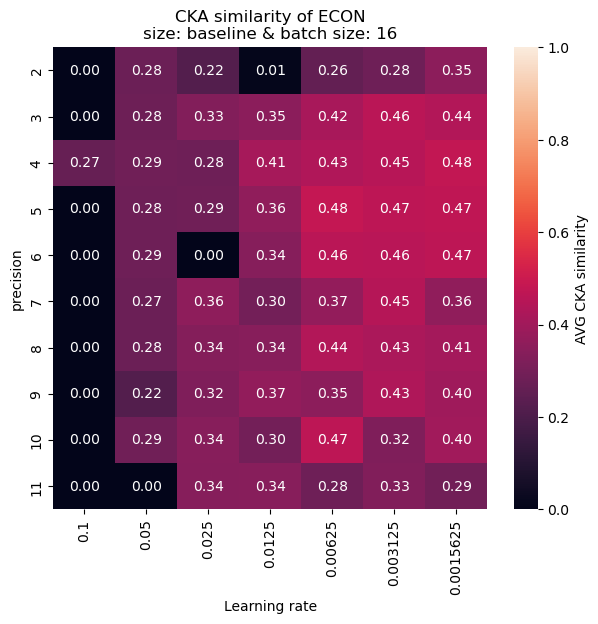

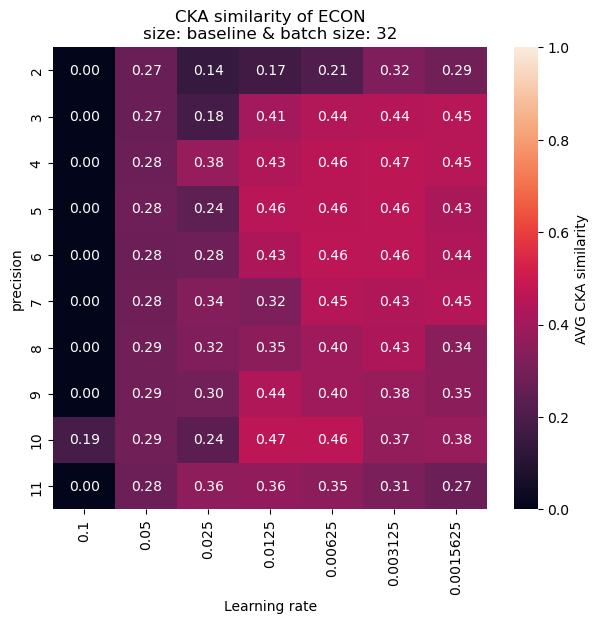

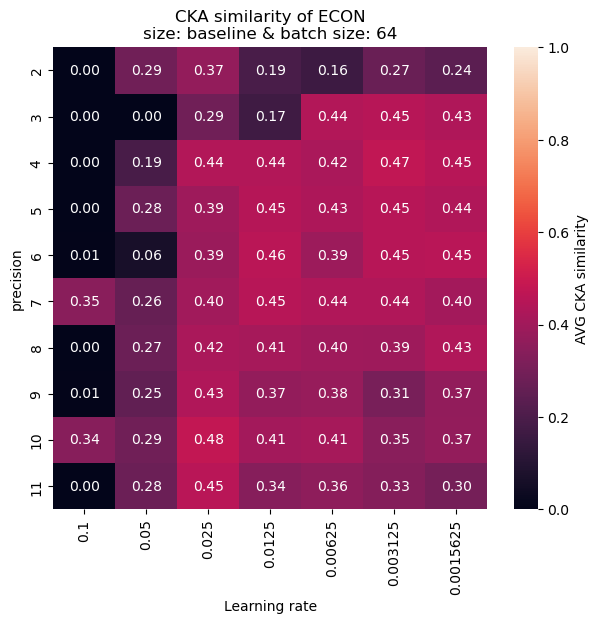

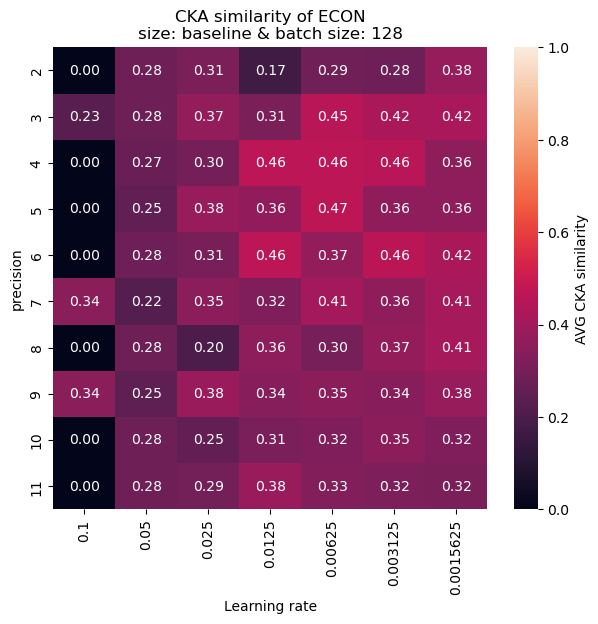

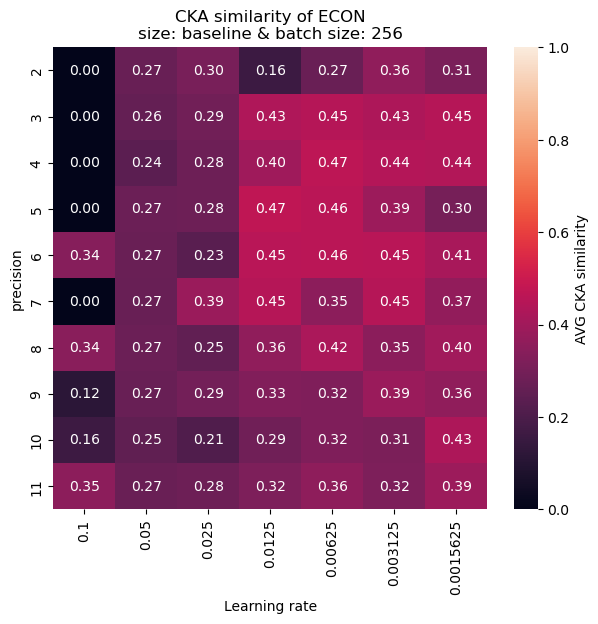

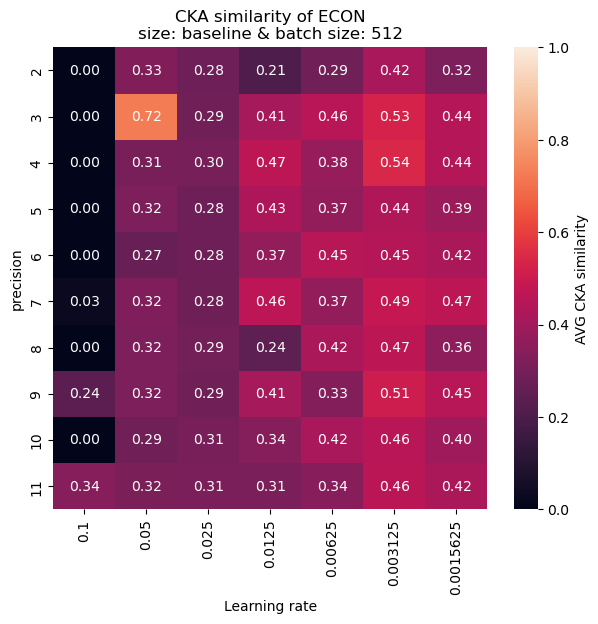

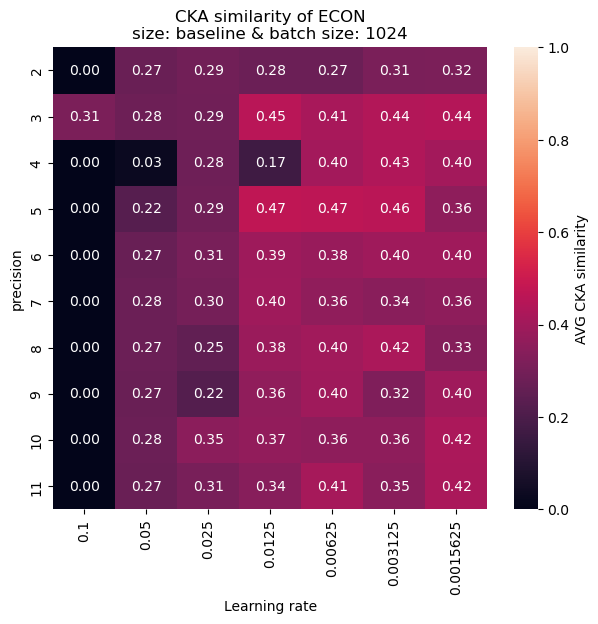

In [9]:
cka_distribution = []
for bs in batch_sizes:
    CKA_matrix = np.zeros((len(precisions), len(learning_rates)))
    for x, p in enumerate(precisions):
        for y, lr in enumerate(learning_rates):
            # path to the directory
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/ECON_{p}b/{size}/')
            # get the metric
            cka = get_cka_per_model(bs,
                                    lr,
                                    p,
                                    size,
                                    cka_dataloader,
                                    ECON_layers,
                                    max_batches=cka_batch_num)
            
            # load the results
            avg_cka = -1
            if cka.load_from_file(path):
                avg_cka = cka.results['CKA_similarity']
                

            # build the heatmap
            CKA_matrix[x, y] = avg_cka
            
    CKA_matrix = pd.DataFrame(CKA_matrix, 
                              index=precisions, 
                              columns=learning_rates)
    plot_2d_heatmap(CKA_matrix, 
                    f'CKA similarity of ECON\nsize: {size} & batch size: {bs}', 
                    (0, 1),
                    'Learning rate',
                    'precision',
                    'AVG CKA similarity',
                    cmap='rocket')

# RN08 (TinyResNet)

In [10]:
DATA_PATH = '/data/tbaldi/work/checkpoint/'
DATASET_DIR = '../../data/RN08'

RN08_layers = [
            'model.conv1', 
            'model.QBlocks.0.conv1', 
            'model.QBlocks.0.conv2', 
            'model.QBlocks.1.conv1', 
            'model.QBlocks.1.conv2',  
            'model.QBlocks.2.conv1', 
            'model.QBlocks.2.conv2',
            'model.QBlocks.2.shortcut',
            'model.QBlocks.3.conv1', 
            'model.QBlocks.3.conv2', 
            'model.QBlocks.4.conv1', 
            'model.QBlocks.4.conv2',
            'model.QBlocks.4.shortcut',
            'model.QBlocks.5.conv1', 
            'model.QBlocks.5.conv2', 
            'model.linear'
        ]

In [11]:
def get_cka_per_model(batch_size, 
                      learning_rate, 
                      precision, 
                      dataloader,
                      activation_layers=ECON_layers,
                      max_batches=cka_batch_num):
    # load the model
    model, _ = rn08.get_model_and_accuracy(DATA_PATH, 
                                           batch_size, 
                                           learning_rate, 
                                           precision)
    
    # init the metric
    cka = CKA(model, 
              dataloader, 
              layers=activation_layers,
              max_batches=max_batches)
    
    return cka

## Result

In [12]:
_, _, cka_dataloader = rn08.get_cifar10_loaders(DATASET_DIR, 256)

Files already downloaded and verified


File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.05/RN08_2b/net_1_best.pkl)
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs32_lr0.00625/RN08_2b/net_1_best.pkl)
File CKA_similarity.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.025/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.025/RN08_2b/net_1_best.pkl)
File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.0125/RN08_2b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs64_lr0.0125/RN08_2b/net_1_best.pkl)
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File not found! (

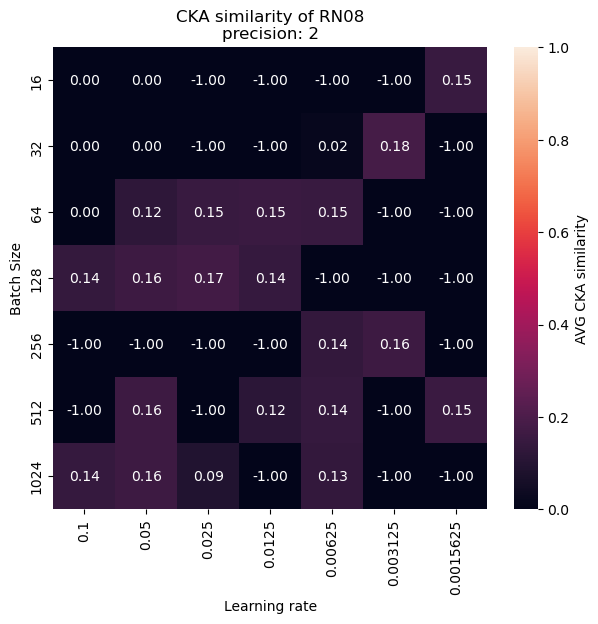

File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!


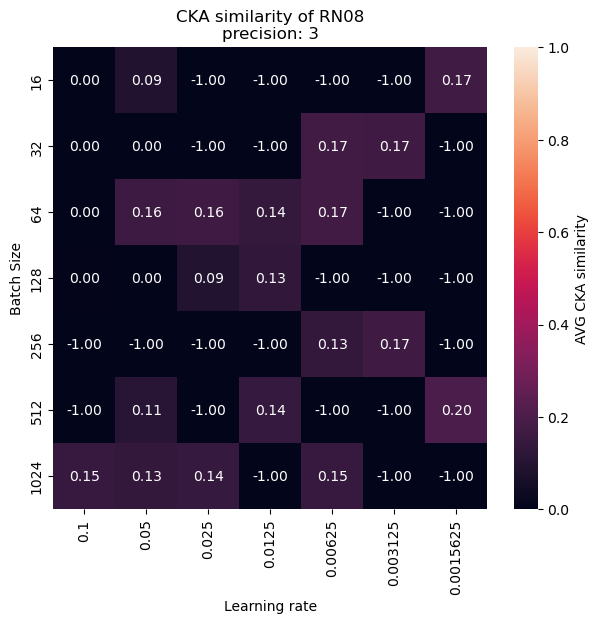

File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_4b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_4b/net_1_best.pkl)
File CKA_similarity.pkl not found!
File CKA_similarity.p

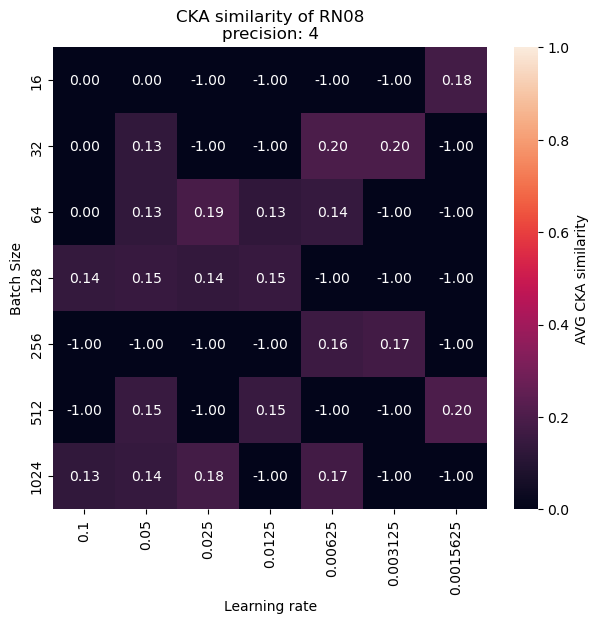

File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!


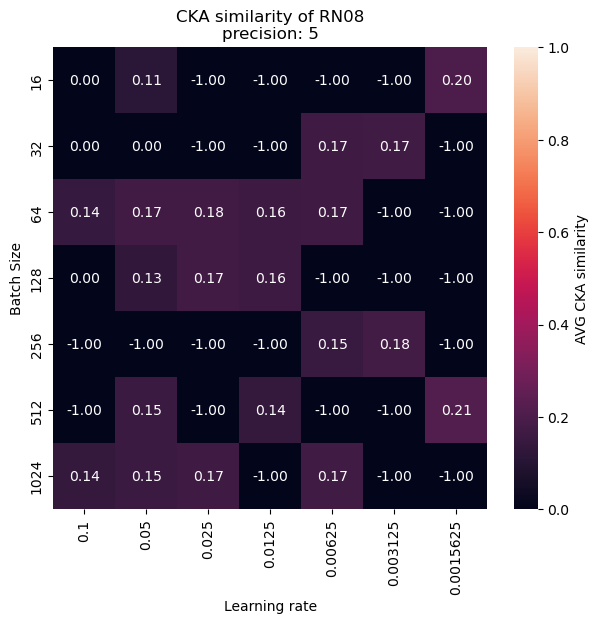

File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_6b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_6b/net_1_best.pkl)
File CKA_similarity.pkl not found!
File CKA_similarity.p

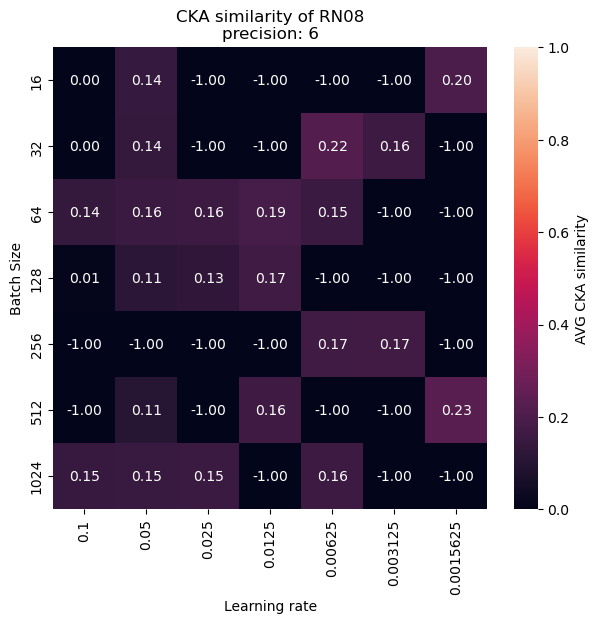

File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_7b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_7b/net_1_best.pkl)
File CKA_similarity.pkl not found!
File CKA_similarity.p

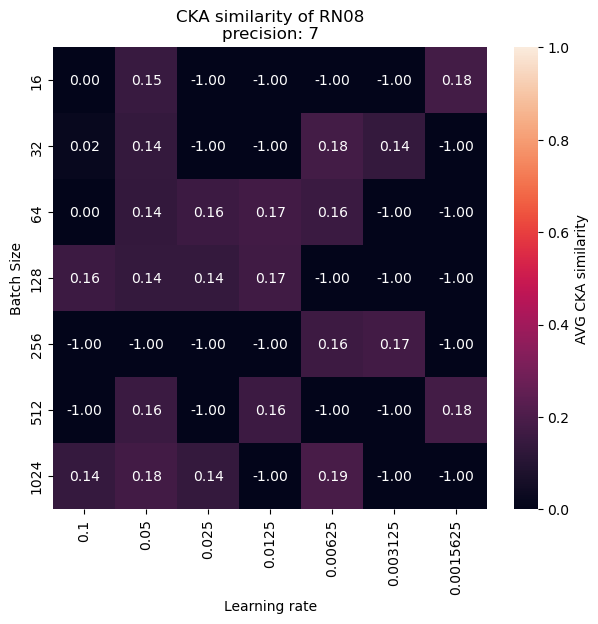

File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!


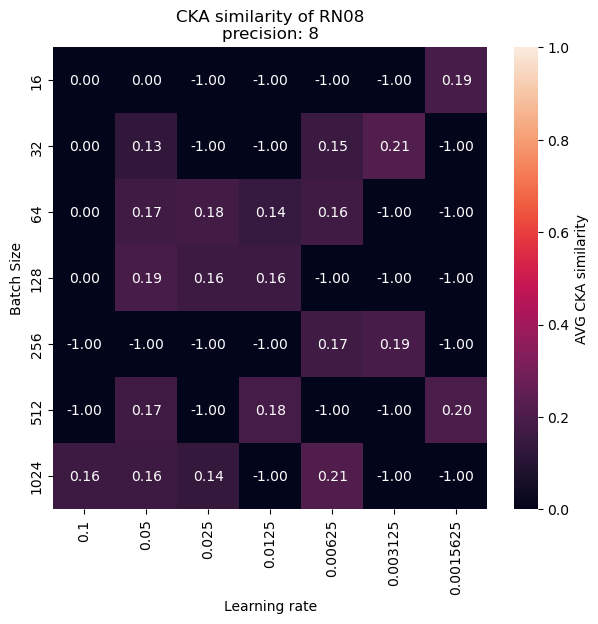

File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!


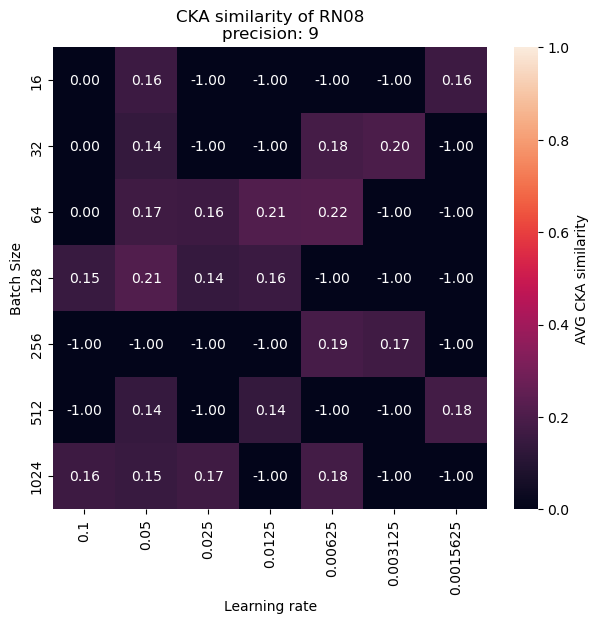

File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!


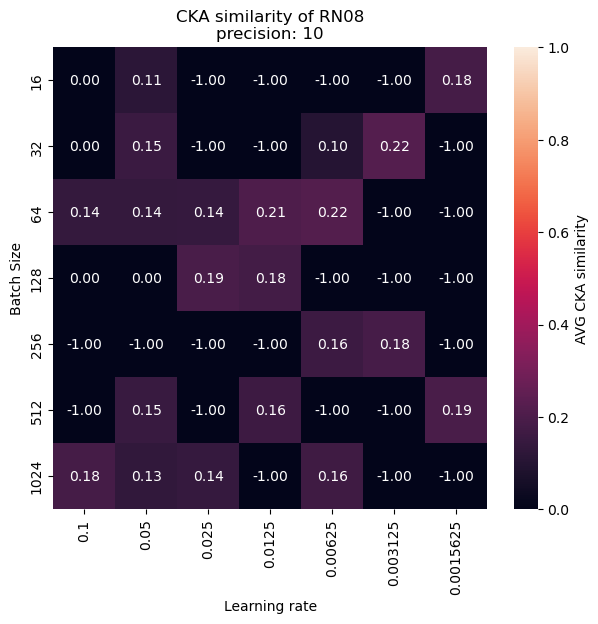

File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File CKA_similarity.pkl not found!
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_11b/accuracy_1.txt)
File not found! (/data/tbaldi/work/checkpoint/bs1024_lr0.00625/RN08_11b/net_1_best.pkl)
File CKA_similarity.pkl not found!
File CKA_similarity

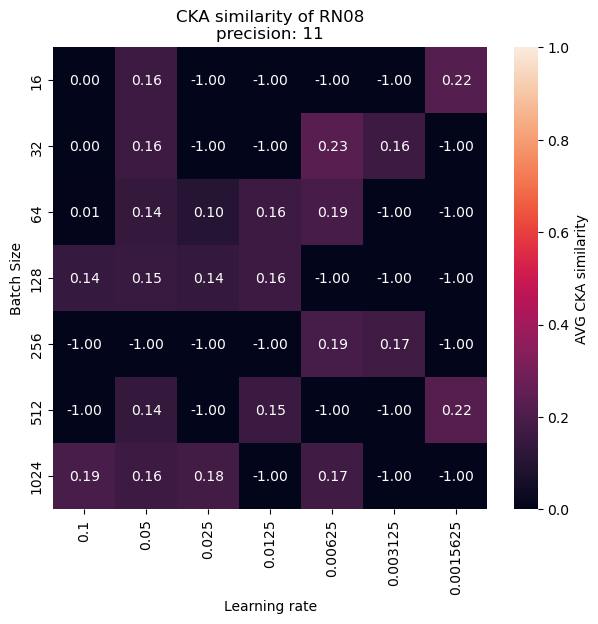

In [13]:
cka_distribution = []
for p in precisions:
    CKA_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            # get the performance of the model with and without noise
            acc = rn08.get_accuracy(DATA_PATH, bs, lr, p)
            # path to the directory
            path = os.path.join(DATA_PATH, f'bs{bs}_lr{lr}/RN08_{p}b/')
            # get the metric
            cka = get_cka_per_model(bs,
                                    lr,
                                    p,
                                    cka_dataloader,
                                    RN08_layers,
                                    max_batches=cka_batch_num)
            
            # load the results
            avg_cka = -1
            if cka.load_from_file(path):
                avg_cka = cka.results['CKA_similarity']
                

            # build the heatmap
            CKA_matrix[x, y] = avg_cka
            
            # build the dataframe for further analysis
            cka_distribution.append({
                'precision': p, 
                'avg_cka': avg_cka,
                'accuracy': acc,
                'batch_size': str(bs),
                'learning_rate': str(lr),
            })
            
            
    CKA_matrix = pd.DataFrame(CKA_matrix, 
                              index=batch_sizes, 
                              columns=learning_rates)
    plot_2d_heatmap(CKA_matrix, 
                    f'CKA similarity of RN08\nprecision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'AVG CKA similarity',
                    cmap='rocket')